In [1]:
print(f"start session")

start session


In [2]:
import gc
import os
import time
import math
from math import exp, log
from collections import Counter
from typing import List, Optional, Union

import numpy as np
import pandas as pd
import transformers
import torch
import heapq
from tqdm import tqdm

import random
import statistics
from collections import Counter
from dataclasses import dataclass
from typing import Any, Callable, List, Optional, Tuple, Union

import torch
import transformers
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig
from pprint import pprint

In [3]:
os.environ['TOKENIZERS_PARALLELISM'] = 'false'

PAD_TOKEN_LABEL_ID = torch.nn.CrossEntropyLoss().ignore_index
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class HuggingFaceModelLoader:
    def __init__(self, model_path: str, load_in_8bit: bool, device_map: str):
        self.model_path = model_path
        self.load_in_8bit = load_in_8bit
        self.device_map = device_map

    def load_model(self) -> transformers.PreTrainedModel:
        if self.load_in_8bit:
            if DEVICE.type != 'cuda':
                raise ValueError('8-bit quantization requires a CUDA device')

            quantization_config = transformers.BitsAndBytesConfig(
                load_in_4bit=True,
                bnb_4bit_quant_type="fp4",
                bnb_4bit_use_double_quant=False,
                bnb_4bit_compute_dtype=torch.float16,
            )

            model = transformers.AutoModelForCausalLM.from_pretrained(
                self.model_path,
                quantization_config=quantization_config,
                device_map=self.device_map
            )
        else:
            model = transformers.AutoModelForCausalLM.from_pretrained(
                self.model_path,
                torch_dtype=torch.float16 if DEVICE.type == 'cuda' else torch.float32,
                device_map=self.device_map
            )

        model.eval()
        return model


class HuggingFaceTokenizer:
    def __init__(self, model_path: str):
        self.tokenizer = transformers.AutoTokenizer.from_pretrained(model_path, padding_side="right")
        self.bos_token = self.tokenizer.bos_token or self.tokenizer.cls_token
        self.eos_token = self.tokenizer.eos_token or self.tokenizer.sep_token
        if self.bos_token is None:
            self.bos_token = ""
        if self.eos_token is None:
            self.eos_token = ""

    def tokenize(self, texts: List[str]) -> dict:
        processed_texts = []

        for text in texts:
            combined_text = f"{self.bos_token}{text}{self.eos_token}"
            processed_texts.append(combined_text)

        model_inputs = self.tokenizer(
            processed_texts,
            return_tensors='pt',
            add_special_tokens=False,
            padding=True
        )

        if 'token_type_ids' in model_inputs:
            model_inputs.pop('token_type_ids')

        return model_inputs


class PerplexityCalculator:
    def __init__(self, model_loader, tokenizer, exp_mode=False):
        self.model = model_loader.load_model()
        self.tokenizer = tokenizer
        self.exp_mode = exp_mode
        self.loss_fct = torch.nn.CrossEntropyLoss(reduction='none')

    def get_perplexity(
        self,
        input_texts: Union[str, List[str]],
        batch_size: int = 32
    ) -> Union[float, List[float]]:

        single_input = isinstance(input_texts, str)
        input_texts = [input_texts] if single_input else input_texts

        loss_list = []
        num_texts = len(input_texts)
        batches = num_texts // batch_size + (num_texts % batch_size != 0)
        with torch.no_grad():
            for j in range(batches):
                start_idx = j * batch_size
                end_idx = (j + 1) * batch_size
                input_batch = input_texts[start_idx:end_idx]

                with torch.no_grad():
                    model_inputs = self.tokenizer.tokenize(input_batch)
                    model_inputs = {k: v.to(DEVICE) for k, v in model_inputs.items()}

                    output = self.model(**model_inputs, use_cache=False)
                    logits = output['logits']

                    label = model_inputs['input_ids']
                    if hasattr(self.model.config, 'pad_token_id') and self.model.config.pad_token_id is not None:
                        label[label == self.model.config.pad_token_id] = PAD_TOKEN_LABEL_ID

                    shift_logits = logits[..., :-1, :].contiguous()
                    shift_labels = label[..., 1:].contiguous()

                    token_loss = self.loss_fct(
                        shift_logits.view(-1, shift_logits.size(-1)),
                        shift_labels.view(-1)
                    ).view(len(logits), -1)

                    valid_length = (shift_labels != PAD_TOKEN_LABEL_ID).sum(dim=-1)
                    sequence_loss = torch.sum(token_loss, -1) / valid_length
                    loss_list.extend(sequence_loss.cpu().tolist())

        if self.exp_mode:
            ppl = [exp(i) for i in loss_list]
        else:
            ppl = loss_list

        return ppl[0] if single_input else ppl

In [4]:
class SimulatedAnnealing:
    def __init__(self, start_temp, end_temp, max_iterations, cost_fn, neighbor_fn, random_state):
        self.start_temp = start_temp
        self.end_temp = end_temp
        self.max_iterations = max_iterations
        self.cost_fn = cost_fn
        self.neighbor_fn = neighbor_fn
        random.seed(random_state)

    def _acceptance_probability(self, diff, temperature):
        if diff <= 0:
            return 1.0
        return exp(-diff/temperature)

    def _lower_temperature(self, temperature, iteration):
        t1 = self.end_temp + self.start_temp/(1 + math.log(iteration+1))
        t2 = self.start_temp + (self.end_temp - self.start_temp)*(iteration/self.max_iterations)
        return max(t1, t2)

    def _print_progress(
        self,
        iteration: int,
        best_solutions: List[List[str]],
        best_energies: List[float],
        current_solutions: List[List[str]],
        current_energies: List[float],
        temperature: float,
        start_time: float,
        spend_minute: int
    ) -> int:
        current_time = time.strftime("%Y-%m-%d %H:%M:%S", time.localtime())
        elapsed_time = time.time() - start_time

        # Check if 60 seconds have passed since the last update
        if elapsed_time - 60 * spend_minute > 60:
            spend_minute += 1
            progress = iteration / self.max_iterations * 100  # Progress as percentage

            # Print progress in a structured format
            print("===== Simulated Annealing Progress =====")
            print(f"Time: {current_time}")
            print(f"Iteration: {iteration}/{self.max_iterations} ({progress:.2f}%)")
            print(f"Temperature: {temperature:.4f}")
            print(f"Elapsed Time: {elapsed_time:.2f} seconds")

            # Print best solutions and energies
            print("\nBest Solutions:")
            idx_items = np.argsort(best_energies)[:5]

            for i, idx in enumerate(idx_items):
                print(f"  Solution {i+1}: {best_solutions[idx]}")
            print("\nBest Energies:")
            print("  " + ", ".join(f"{best_energies[idx]:.4f}" for idx in idx_items))

            # Print current solutions and energies
            print("\nCurrent Solutions:")
            for i, solution in enumerate(current_solutions[:5]):
                print(f"  Solution {i+1}: {solution}")
            print("\nCurrent Energies:")
            print("  " + ", ".join(f"{energy:.4f}" for energy in current_energies[:5]))

            print("========================================\n")

        return spend_minute


    def solve_batch(self, text_list, max_minute=60):
        """
        Perform Simulated Annealing for multiple texts at once.
        """
        solutions = text_list[:]
        current_energies = self.cost_fn(solutions)

        best_solutions = solutions[:]
        best_energies = current_energies[:]

        log_energies = [[] for _ in range(len(text_list))]
        for i in range(len(text_list)):
            log_energies[i].append(current_energies[i])

        temperature = self.start_temp
        start_time = time.time()
        spend_minute = 0

        for iteration in range(self.max_iterations):
            # 1) Generate neighbors
            new_solutions = [self.neighbor_fn(sol) for sol in solutions]

            # 2) Calculate new energies in batch
            new_energies = self.cost_fn(new_solutions)

            # 3) Acceptance and update
            for i in range(len(text_list)):

                diff = new_energies[i] - current_energies[i]
                ap = self._acceptance_probability(diff, temperature)

                if random.random() < ap:
                    solutions[i] = new_solutions[i]
                    current_energies[i] = new_energies[i]

                if current_energies[i] < best_energies[i]:
                    best_solutions[i] = solutions[i][:]
                    best_energies[i] = current_energies[i]

            # 4) Lower temperature
            temperature = self._lower_temperature(temperature, iteration)

            # 5) Log current energies
            for i in range(len(text_list)):
                log_energies[i].append(current_energies[i])

            # 6) Print progress (extracted into separate method)
            spend_minute = self._print_progress(
                iteration,
                best_solutions,
                best_energies,
                solutions,
                current_energies,
                temperature,
                start_time,
                spend_minute
            )

            # 7) Early stop if temperature is below threshold
            if temperature <= self.end_temp or spend_minute >= max_minute:
                print("Exiting.")
                break

        print(f"Execution time: {time.time() - start_time:.4f}s")

        # Convert best solutions back to strings
        return best_solutions, best_energies, log_energies

In [5]:
import random
from typing import List

class TSPListOperations:
    @staticmethod
    def two_rotation(item: List[str]) -> List[str]:
        i, j = random.sample(range(len(item)), 2)
        # Rotate two elements: (i, j) -> (j, i)
        item[i], item[j] = item[j], item[i]
        return item
    
    @staticmethod
    def random_rotation(item: List[str]) -> List[str]:
        if len(item) < 2:
            return item

        start_idx, end_idx = sorted(random.sample(range(len(item)), 2))

        shift = random.randint(1, len(item) - 1)
        sublist = item[start_idx:end_idx + 1]

        shift = shift % len(sublist)  # Normalize shift within sublist length
        sublist = sublist[shift:] + sublist[:shift]

        item[start_idx:end_idx + 1] = sublist

        return item

    @staticmethod
    def random_insertion(item: List[str]) -> List[str]:
        if len(item) < 2:
            return item
        
        size = random.randint(2, min(8, len(item)))
        start = random.randint(0, len(item)-size-1)
        end = start + size

        if random.random() < 0.5:
            elem = item.pop(end)
            item.insert(start, elem)
        else:
            elem = item.pop(start)
            item.insert(end, elem)
        return item

    @staticmethod
    def shuffle_sublist(item: List[str]) -> List[str]:
        if len(item) < 2:
            return item

        size = random.randint(2, min(8, len(item)))
        start = random.randint(0, len(item) - size-1)
        end = start + size - 1
        random.shuffle(item[start:end + 1])
        return item

    @staticmethod
    def double_bridge_move(item: List[str]) -> List[str]:
        n = len(item)
        
        size_B = random.randint(1, 4)  
        size_C = random.randint(1, 2)  
        size_D = random.randint(1, 4)  
        
        size_A = random.randint(0, n - (size_B + size_C + size_D))
        size_E = n - (size_A + size_B + size_C + size_D)
        
        # (3) a, b, c, d 계산
        a = size_A
        b = a + size_B
        c = b + size_C
        d = c + size_D
     
        A = item[:a]
        B = item[a:b]
        C = item[b:c]
        D = item[c:d]
        E = item[d:]

        if random.choice([True, False]):
            B = B[::-1]
        if random.choice([True, False]):
            D = D[::-1]

        return A + D + C + B + E


In [6]:
def cost_fn(sols, batch_size=10):
  return scorer.get_perplexity(sols, batch_size=batch_size)

def neighbor_fn(arr: str, prefix: int = 0, suffix: int = 0) -> str:
    item = arr.split()
    operations = [
        TSPListOperations.two_rotation,
        TSPListOperations.random_rotation,
        TSPListOperations.random_insertion,
        TSPListOperations.shuffle_sublist,
        TSPListOperations.double_bridge_move,
    ]

    op = random.choice(operations)
    item_modified = item[:prefix] + op(item[prefix:len(item)-suffix]) + item[len(item)-suffix:]
    return ' '.join(item_modified)

In [7]:
model_path = "/kaggle/input/gemma-2/transformers/gemma-2-9b/2"
model_loader = HuggingFaceModelLoader(model_path=model_path, load_in_8bit=False, device_map='auto')
tokenizer = HuggingFaceTokenizer(model_path)
scorer = PerplexityCalculator(model_loader, tokenizer, exp_mode=True)

Loading checkpoint shards:   0%|          | 0/8 [00:00<?, ?it/s]

In [8]:
def average_increment(current_T0, uphill_diffs, p0):
    epsilon = 1e-12

    total_temperatures = []
    for diff in uphill_diffs:
        exponent = -diff / (current_T0 + epsilon)
        exponent = max(min(exponent, 700), -700)
        temperature = math.exp(exponent)
        total_temperatures.append(temperature)
        
    avg_exp = sum(total_temperatures) / len(total_temperatures)
    return avg_exp - p0

def estimate_initial_temperature(uphill_diffs, p0=0.1):
    
    num_uphill_diffs = len(uphill_diffs)
    if num_uphill_diffs == 0:
        return -1.0 / math.log(p0 + 1e-12)

    epsilon = 1e-12
    max_uphill_diff = max(uphill_diffs)
    low = epsilon
    high = max_uphill_diff * 100.0

    for _ in range(500):
        mid = (low + high) / 2.0
        val = average_increment(current_T0=mid, 
                                 uphill_diffs=uphill_diffs, 
                                 p0=p0)
        if val > 0:
            high = mid
        else:
            low = mid

    return (low + high) / 2.0

In [9]:
torch.cuda.empty_cache()

In [58]:
PREFIX_LENGTH = 1
SUFFIX_LENGTH = 0

sa_params = {
    'start_temp': 100.0,             # Initial temperature
    'end_temp': 0.005,          # Final temperature, decreasing linearly
    'max_iterations': 10000,    
    'random_state': 42,          # Seed for the random number generator to ensure reproducibility
    "cost_fn": cost_fn,
    "neighbor_fn": lambda x: neighbor_fn(x, prefix=PREFIX_LENGTH, suffix=SUFFIX_LENGTH)
}

# Initialize the SimulatedAnnealing optimizer with the specified parameters
sa_optimizer = SimulatedAnnealing(**sa_params)

In [59]:
def shuffle_text(text: str) -> str:
    words = text.split()
    if len(words) <= 1:
        return text  # 単語が1つ以下の場合はそのまま返す
    first_word = words[0]
    remaining_words = words[1:]
    random.shuffle(remaining_words)
    return ' '.join([first_word] + remaining_words)


In [60]:
start_text = 'reindeer sleep walk the night and drive mistletoe scrooge laugh chimney jump elf bake gingerbread family give advent fireplace ornament'

print(cost_fn(start_text))
nei = sa_params['neighbor_fn']
seqs = []
while len(seqs) < 100:
    start_text = shuffle_text(start_text)
    seqs.append(start_text)
for s in seqs:
    print(s)

421.72903972489905
reindeer family gingerbread and chimney drive give fireplace mistletoe bake advent jump walk elf the ornament scrooge laugh sleep night
reindeer ornament bake chimney walk jump laugh gingerbread elf give night and family drive advent scrooge mistletoe the fireplace sleep
reindeer scrooge advent sleep laugh and chimney jump night gingerbread bake mistletoe elf the ornament drive give fireplace family walk
reindeer scrooge the give mistletoe gingerbread walk elf chimney fireplace and jump drive laugh ornament family bake night advent sleep
reindeer laugh drive ornament and sleep family the scrooge bake mistletoe fireplace jump gingerbread elf night advent chimney walk give
reindeer mistletoe laugh drive night bake gingerbread family elf and jump sleep ornament scrooge walk chimney advent give fireplace the
reindeer walk elf jump gingerbread the and night chimney family ornament sleep fireplace laugh mistletoe scrooge drive advent give bake
reindeer advent ornament mist

In [61]:
best_solutions, best_energies, log_scores = sa_optimizer.solve_batch(seqs, max_minute=60*5)

===== Simulated Annealing Progress =====
Time: 2025-01-04 17:48:34
Iteration: 14/10000 (0.14%)
Temperature: 99.8600
Elapsed Time: 62.81 seconds

Best Solutions:
  Solution 1: reindeer jump scrooge walk mistletoe sleep elf bake gingerbread ornament give drive the chimney advent night fireplace laugh family and
  Solution 2: reindeer jump the scrooge walk and drive family give gingerbread chimney ornament night mistletoe sleep elf advent laugh bake fireplace
  Solution 3: reindeer jump gingerbread family give advent the night mistletoe scrooge walk and drive laugh fireplace chimney ornament elf sleep bake
  Solution 4: reindeer jump scrooge the mistletoe give laugh bake advent and chimney walk elf family ornament night drive fireplace sleep gingerbread
  Solution 5: reindeer walk gingerbread ornament elf give and bake family laugh sleep the night chimney advent scrooge fireplace mistletoe jump drive

Best Energies:
  1218.0537, 1262.1093, 1297.7137, 1357.8125, 1382.4923

Current Solution

In [62]:
print(best_solutions)

['reindeer sleep walk drive laugh jump mistletoe night ornament advent give and bake chimney scrooge the elf family fireplace gingerbread', 'reindeer mistletoe elf gingerbread ornament scrooge and family chimney fireplace laugh sleep bake walk jump drive advent give the night', 'reindeer jump scrooge walk the night drive mistletoe sleep laugh and give advent fireplace chimney elf family gingerbread bake ornament', 'reindeer mistletoe elf gingerbread chimney fireplace night sleep walk drive laugh jump give bake the scrooge ornament advent and family', 'reindeer walk elf drive scrooge sleep gingerbread bake chimney jump mistletoe ornament fireplace advent give family laugh and the night', 'reindeer jump the scrooge mistletoe chimney and elf gingerbread bake walk sleep drive give advent family laugh fireplace ornament night', 'reindeer sleep walk and drive mistletoe jump scrooge laugh elf bake gingerbread give advent the night chimney ornament family fireplace', 'reindeer mistletoe elf gi

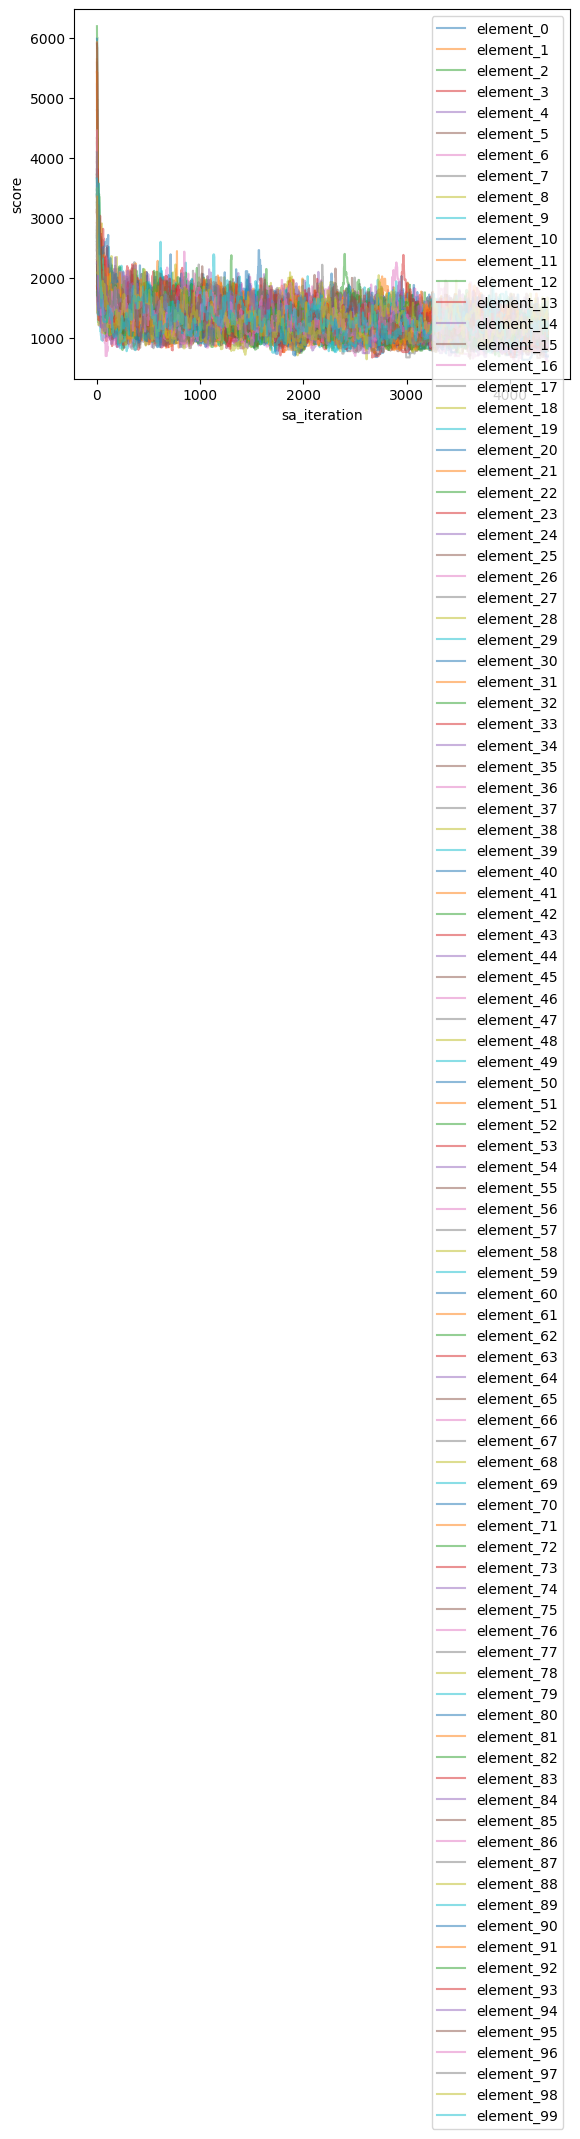

In [63]:
# To visualize whether the scores decreased appropriately, you can use matplotlib to create a plot.

import matplotlib.pyplot as plt
for idx, elem in enumerate(log_scores):
    plt.plot(elem, label=f'element_{idx}', alpha=0.5)
plt.xlabel('sa_iteration')
plt.ylabel('score')
plt.legend()
plt.show()



In [64]:
for i in range(len(best_solutions):
    print(best_energies[i], best_solutions[i])

SyntaxError: invalid syntax (<ipython-input-64-a97d88f04664>, line 1)

In [8]:
texts = ['reindeer sleep walk drive laugh jump mistletoe night ornament advent give and bake chimney scrooge the elf family fireplace gingerbread', 'reindeer mistletoe elf gingerbread ornament scrooge and family chimney fireplace laugh sleep bake walk jump drive advent give the night', 'reindeer jump scrooge walk the night drive mistletoe sleep laugh and give advent fireplace chimney elf family gingerbread bake ornament', 'reindeer mistletoe elf gingerbread chimney fireplace night sleep walk drive laugh jump give bake the scrooge ornament advent and family', 'reindeer walk elf drive scrooge sleep gingerbread bake chimney jump mistletoe ornament fireplace advent give family laugh and the night', 'reindeer jump the scrooge mistletoe chimney and elf gingerbread bake walk sleep drive give advent family laugh fireplace ornament night', 'reindeer sleep walk and drive mistletoe jump scrooge laugh elf bake gingerbread give advent the night chimney ornament family fireplace', 'reindeer mistletoe elf gingerbread ornament family fireplace laugh sleep walk and jump drive give bake advent the night scrooge chimney', 'reindeer sleep drive give the night and scrooge laugh mistletoe walk gingerbread fireplace chimney elf jump ornament family advent bake', 'reindeer and elf family jump scrooge laugh drive walk gingerbread bake the ornament give chimney fireplace night sleep advent mistletoe', 'reindeer mistletoe scrooge gingerbread chimney elf ornament family fireplace drive walk sleep give laugh jump bake the night and advent', 'reindeer sleep walk drive the mistletoe give and laugh jump bake scrooge gingerbread fireplace elf chimney ornament family night advent', 'reindeer mistletoe scrooge gingerbread ornament the fireplace chimney elf sleep bake advent family night drive walk jump and laugh give', 'reindeer sleep drive walk give jump and laugh mistletoe elf bake the night scrooge fireplace advent ornament gingerbread chimney family', 'reindeer sleep walk drive laugh the night and mistletoe scrooge jump family give advent bake ornament elf gingerbread chimney fireplace', 'reindeer sleep walk jump drive night mistletoe the elf give and bake advent scrooge family laugh gingerbread ornament chimney fireplace', 'reindeer and elf walk gingerbread bake scrooge drive family laugh give chimney jump the night sleep mistletoe advent fireplace ornament', 'reindeer jump the scrooge gingerbread give and bake laugh sleep night drive elf walk mistletoe family fireplace ornament advent chimney', 'reindeer and mistletoe family jump sleep walk laugh bake advent scrooge ornament elf drive chimney fireplace gingerbread give the night', 'reindeer sleep drive mistletoe and gingerbread walk bake the night jump scrooge elf give laugh family advent fireplace ornament chimney', 'reindeer mistletoe scrooge chimney elf fireplace advent gingerbread ornament family sleep drive walk laugh jump and bake the night give', 'reindeer sleep walk gingerbread drive bake and give chimney jump family night mistletoe laugh fireplace ornament advent scrooge the elf', 'reindeer sleep drive laugh give bake walk the night and jump elf scrooge gingerbread ornament mistletoe chimney fireplace family advent', 'reindeer mistletoe scrooge ornament advent elf bake gingerbread family sleep the night drive walk chimney jump fireplace laugh and give', 'reindeer walk gingerbread bake the night and sleep drive scrooge jump elf laugh family give advent mistletoe chimney fireplace ornament', 'reindeer and family sleep drive walk laugh jump bake advent scrooge mistletoe gingerbread chimney fireplace ornament elf give the night', 'reindeer mistletoe scrooge gingerbread ornament elf advent fireplace chimney bake walk drive jump laugh sleep the night family and give', 'reindeer sleep walk drive jump laugh scrooge mistletoe advent fireplace ornament give and bake gingerbread chimney the night elf family', 'reindeer jump scrooge walk the night laugh elf sleep gingerbread drive mistletoe give and bake advent family chimney fireplace ornament', 'reindeer sleep drive give and laugh walk scrooge jump elf bake the night mistletoe gingerbread ornament family fireplace chimney advent', 'reindeer sleep drive the mistletoe jump give and bake laugh advent scrooge family night walk fireplace gingerbread chimney elf ornament', 'reindeer walk gingerbread drive family sleep bake elf laugh give chimney fireplace ornament jump night advent scrooge and the mistletoe', 'reindeer walk gingerbread bake elf jump ornament give family sleep the scrooge laugh night and drive chimney fireplace mistletoe advent', 'reindeer the night walk and sleep drive laugh jump give advent scrooge mistletoe gingerbread bake ornament family chimney fireplace elf', 'reindeer sleep drive walk jump bake laugh give advent mistletoe gingerbread the night elf and scrooge ornament family chimney fireplace', 'reindeer sleep drive and laugh the elf walk jump bake night scrooge mistletoe gingerbread family give advent chimney fireplace ornament', 'reindeer mistletoe jump scrooge drive and give laugh sleep walk bake the fireplace gingerbread elf ornament advent chimney family night', 'reindeer sleep walk gingerbread bake elf jump scrooge give laugh advent night mistletoe chimney fireplace ornament family and the drive', 'reindeer mistletoe jump and bake gingerbread laugh walk sleep the fireplace drive give chimney elf night advent scrooge family ornament', 'reindeer drive scrooge and the mistletoe walk gingerbread bake chimney jump fireplace sleep elf laugh advent ornament give family night', 'reindeer and scrooge ornament gingerbread family advent night sleep elf bake walk drive chimney give the fireplace jump mistletoe laugh', 'reindeer drive walk the chimney give and bake laugh jump sleep scrooge gingerbread family ornament elf advent fireplace night mistletoe', 'reindeer the mistletoe scrooge chimney fireplace advent elf ornament gingerbread bake night family sleep drive give laugh walk and jump', 'reindeer mistletoe gingerbread chimney bake drive walk sleep the night give laugh and jump advent scrooge elf ornament family fireplace', 'reindeer drive chimney jump the scrooge and family night walk fireplace elf sleep gingerbread bake mistletoe ornament give laugh advent', 'reindeer mistletoe scrooge gingerbread ornament bake advent family chimney sleep drive walk laugh give jump and the fireplace elf night', 'reindeer sleep drive and laugh walk jump the elf night scrooge gingerbread bake mistletoe chimney fireplace ornament family advent give', 'reindeer sleep walk drive give and the elf laugh jump night bake mistletoe family advent scrooge ornament gingerbread fireplace chimney', 'reindeer mistletoe scrooge chimney bake and give laugh sleep advent walk jump drive the night elf gingerbread ornament family fireplace', 'reindeer mistletoe scrooge elf gingerbread chimney fireplace ornament advent bake sleep walk jump drive give laugh the night and family', 'reindeer sleep elf walk gingerbread bake chimney jump and the night scrooge drive family give advent laugh fireplace ornament mistletoe', 'reindeer drive and jump scrooge the mistletoe give laugh sleep advent gingerbread bake chimney elf night walk fireplace ornament family', 'reindeer and elf family sleep walk night drive laugh give advent bake mistletoe jump the scrooge gingerbread ornament chimney fireplace', 'reindeer elf gingerbread family bake walk jump drive give laugh and sleep the chimney night scrooge mistletoe ornament advent fireplace', 'reindeer mistletoe gingerbread laugh sleep bake walk jump drive the night and give advent family scrooge elf chimney fireplace ornament', 'reindeer drive chimney jump and sleep scrooge the night mistletoe walk elf give laugh gingerbread family bake ornament advent fireplace', 'reindeer walk gingerbread drive the elf give and bake sleep scrooge chimney jump mistletoe laugh advent fireplace ornament family night', 'reindeer mistletoe gingerbread drive walk laugh jump sleep bake the night and give advent fireplace chimney elf ornament scrooge family', 'reindeer mistletoe scrooge gingerbread family chimney ornament elf bake walk drive laugh jump sleep give advent fireplace and the night', 'reindeer mistletoe elf scrooge gingerbread advent chimney fireplace ornament sleep walk laugh give jump bake drive night and the family', 'reindeer walk gingerbread bake elf jump mistletoe laugh advent chimney drive the night and sleep ornament scrooge give family fireplace', 'reindeer sleep drive the night mistletoe jump give and scrooge walk elf laugh gingerbread bake family chimney fireplace ornament advent', 'reindeer sleep drive walk jump the night scrooge and mistletoe laugh family fireplace give bake ornament gingerbread elf advent chimney', 'reindeer sleep drive walk jump the night mistletoe laugh chimney fireplace elf gingerbread ornament bake and give family advent scrooge', 'reindeer walk gingerbread bake scrooge laugh and jump the chimney elf drive family night sleep mistletoe give advent fireplace ornament', 'reindeer sleep walk drive laugh give bake jump the night mistletoe and chimney advent scrooge elf gingerbread ornament family fireplace', 'reindeer walk gingerbread bake elf drive scrooge give laugh sleep the night and mistletoe jump chimney fireplace ornament family advent', 'reindeer sleep drive the night scrooge walk mistletoe jump family laugh fireplace gingerbread give and bake advent chimney ornament elf', 'reindeer mistletoe scrooge chimney elf advent fireplace ornament family gingerbread bake sleep drive walk jump laugh give and the night', 'reindeer drive sleep walk the elf give and bake family laugh night advent scrooge chimney fireplace mistletoe gingerbread ornament jump', 'reindeer sleep drive the mistletoe give and laugh bake gingerbread walk family night jump scrooge chimney advent fireplace ornament elf', 'reindeer sleep drive the night scrooge laugh family give mistletoe gingerbread bake ornament chimney advent fireplace elf jump and walk', 'reindeer sleep walk drive laugh the night jump scrooge mistletoe ornament elf advent gingerbread give and bake chimney family fireplace', 'reindeer walk gingerbread bake scrooge sleep elf jump ornament give family night drive the fireplace and chimney laugh advent mistletoe', 'reindeer the gingerbread bake walk laugh and jump sleep drive give advent family night fireplace chimney elf scrooge mistletoe ornament', 'reindeer the night and drive give laugh sleep elf gingerbread bake chimney walk fireplace jump scrooge family advent ornament mistletoe', 'reindeer walk the night and drive jump scrooge laugh mistletoe sleep elf bake gingerbread family give advent fireplace ornament chimney', 'reindeer sleep walk drive laugh bake the fireplace mistletoe and elf jump chimney scrooge advent ornament gingerbread give family night', 'reindeer sleep drive the night give and scrooge laugh mistletoe family fireplace walk jump elf gingerbread bake ornament advent chimney', 'reindeer walk gingerbread bake elf laugh give and drive the fireplace chimney jump sleep scrooge night mistletoe ornament advent family', 'reindeer sleep walk gingerbread laugh bake chimney jump scrooge give the night and drive mistletoe elf family advent fireplace ornament', 'reindeer drive family sleep walk gingerbread bake chimney elf laugh fireplace jump mistletoe ornament advent night give and the scrooge', 'reindeer and elf walk gingerbread drive bake ornament give laugh the night mistletoe family fireplace advent jump sleep scrooge chimney', 'reindeer mistletoe elf gingerbread jump scrooge drive walk give sleep bake and laugh the fireplace chimney ornament advent night family', 'reindeer and elf ornament family gingerbread bake walk drive jump sleep laugh give scrooge advent fireplace chimney mistletoe the night', 'reindeer sleep and drive mistletoe walk gingerbread laugh chimney jump fireplace bake the night give advent scrooge elf ornament family', 'reindeer jump the scrooge laugh and walk gingerbread drive fireplace bake elf give chimney sleep advent mistletoe family ornament night', 'reindeer mistletoe the elf scrooge ornament family gingerbread fireplace chimney drive night sleep walk jump give bake and laugh advent', 'reindeer mistletoe gingerbread bake walk jump drive give laugh night elf sleep family ornament advent scrooge fireplace and the chimney', 'reindeer sleep drive scrooge walk gingerbread bake chimney elf night the fireplace ornament family laugh and jump give advent mistletoe', 'reindeer drive and jump scrooge walk laugh bake gingerbread give chimney the fireplace elf night sleep mistletoe ornament advent family', 'reindeer jump scrooge drive family walk gingerbread bake the chimney fireplace elf night sleep and give laugh mistletoe ornament advent', 'reindeer jump the scrooge mistletoe drive family night sleep walk laugh elf give and bake chimney fireplace gingerbread ornament advent', 'reindeer and elf ornament family gingerbread bake laugh give advent scrooge the chimney sleep night drive mistletoe fireplace jump walk', 'reindeer and elf drive walk gingerbread bake ornament give advent scrooge laugh chimney jump family sleep the mistletoe night fireplace', 'reindeer drive walk sleep bake give jump laugh advent scrooge and the chimney fireplace night mistletoe elf ornament gingerbread family', 'reindeer walk the night and drive sleep gingerbread bake chimney scrooge jump elf laugh mistletoe family give fireplace ornament advent', 'reindeer sleep walk drive laugh give jump bake the night scrooge and family fireplace chimney advent ornament mistletoe gingerbread elf', 'reindeer mistletoe scrooge elf ornament family advent fireplace gingerbread chimney bake walk jump drive sleep laugh give and the night', 'reindeer the night and drive sleep scrooge walk laugh mistletoe elf jump family give bake gingerbread chimney fireplace ornament advent']
best_score = 1 << 60
best_text = ""
for text in texts:
    score = cost_fn(text)
    if score < best_score:
        best_score = score
        best_text = text

print(f"{best_score}, {best_text}")

594.4398273160831, reindeer sleep walk and drive mistletoe jump scrooge laugh elf bake gingerbread give advent the night chimney ornament family fireplace
